In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


UAVid dataset: https://uavid.nl/

Steps:
 - Install Pytorch via Pip/Conda https://pytorch.org/get-started/locally/
 - Download dataset via link: https://disk.yandex.ru/d/Mw39uGBey44azw
 - Extract dataset zip archive
 - Change `DATASET_DIR` accordingly
 - Implement `UAVIDDataset`.
 - Run the whole notebook to assess SegNet of `UAVIDSemanticSegmentationModel`
 - Modify code of `UAVIDSemanticSegmentationModel` to boost semantic segmentation quality quality of test images. You can choose UNet, PSPnet, DeepLab or something else.

In [ ]:
import os
import cv2
import numpy as np
import ipywidgets
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from typing import Optional

import matplotlib.pyplot as plt
%matplotlib inline

# from .one_hot import one_hot
from typing import Optional

import albumentations as A

# Dataset

In [ ]:
class UAVIDDataset(Dataset):
    def __init__(self, dataset_dir: str, image_height: int, image_width: int, train: bool = False):
        super(UAVIDDataset, self).__init__()
        self.dataset_dir = dataset_dir
        self.image_height = image_height
        self.image_width = image_width
        self.train = train
        
        dir_suffix = 'train/seq1' if self.train else 'val/seq16'
        
        self.image_dir = f'{self.dataset_dir}/uavid_{dir_suffix}/Images/'
        self.label_path = f'{self.dataset_dir}/uavid_{dir_suffix}/Labels/'

        self.index = list(sorted(os.listdir(self.image_dir)))
        
        # color table.
        self.clr_tab = self.createColorTable()

        # id table.
        id_tab = {}
        for k, v in self.clr_tab.items():
            id_tab[k] = self.clr2id(v)
        self.id_tab = id_tab        
        
        self.transform = transforms.Compose(
            [ 
                transforms.ToTensor(),
                transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2))
             
                # transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.2, hue=0.2),
                # transforms.RandomHorizontalFlip(),
            ]
        )

        
    def __getitem__(self, index):
        image = self.get_np_image(index)
        image = np.array(image / 255, dtype=np.float32)
        image = self.transform(image)
        
        label = self.get_np_label(index)
        label = self.label_transform(label).astype(np.compat.long)
        label = torch.from_numpy(label)
        
        return image, label
        
    def get_np_image(self, index): #+
        image = cv2.imread(f'{self.image_dir}/{self.index[index]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.image_width, self.image_height), interpolation=cv2.INTER_CUBIC)
        return image
    
    def get_np_label(self, index): #+
        image = cv2.imread(f'{self.label_path}/{self.index[index]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.image_width, self.image_height), interpolation=cv2.INTER_CUBIC)
        
        return image
    
    def __len__(self):
        return len(self.index)
    
    def createColorTable(self):
        clr_tab = {}
        clr_tab['Clutter'] = [0, 0, 0]
        clr_tab['Building'] = [128, 0, 0]
        clr_tab['Road'] = [128, 64, 128]
        clr_tab['Static_Car'] = [192, 0, 192]
        clr_tab['Tree'] = [0, 128, 0]
        clr_tab['Vegetation'] = [128, 128, 0]
        clr_tab['Human'] = [64, 64, 0]
        clr_tab['Moving_Car'] = [64, 0, 128]
        
        return clr_tab

    def colorTable(self):
        return self.clr_tab

    def clr2id(self, clr):
        return clr[0]+clr[1]*255+clr[2]*255*255
    
    #transform to uint8 integer label
    def label_transform(self,label, dtype=np.int32):
        height,width = label.shape[:2]
        # default value is index of clutter.
        newLabel = np.zeros((height, width), dtype=dtype)
        id_label = label.astype(np.int64)
        id_label = id_label[:,:,0]+id_label[:,:,1]*255+id_label[:,:,2]*255*255
        for tid,key in enumerate(self.clr_tab.keys()):
            val = self.id_tab[key]
            mask = (id_label == val)
            newLabel[mask] = tid
            
        return newLabel

    #transform back to 3 channels uint8 label
    def inverse_transform(self, label):
        label_img = np.zeros(shape=(label.shape[0], label.shape[1],3),dtype=np.uint8)
        values = list(self.clr_tab.values())
        for tid,val in enumerate(values):
            mask = (label==tid)
            label_img[mask] = val
            
        return label_img

def create_dataloader(dataset: Dataset, batch_size: int, num_workers: int, train: bool = False):
    return DataLoader(
        dataset=dataset, batch_size=batch_size, 
        shuffle=train, num_workers=num_workers,
        pin_memory=True, drop_last=False)

# Metric

In [ ]:
class IOU(nn.Module):
    def __init__(self, eps=1.0, activation=None):
        super().__init__()
        self.eps = eps
        if activation is None:
            self.activation = torch.sigmoid
        else:
            self.activation = activation

    def forward(self, y_pr, y_gt):
        if self.activation is not None:
            y_pr = self.activation(y_pr)
        y_pr = y_pr > 0.5
        y_gt = gt_to_stacked(y_pr, y_gt)
        return get_iou(y_pr, y_gt, eps=self.eps)

    
def gt_to_stacked(pred, gt):
    stacked = torch.zeros_like(pred)
    for i in range(pred.shape[1]):
        stacked[:, i, ...] = gt == i
    return stacked
    
    
def get_iou(pr, gt, eps=1e-6):    
    ious = list()
    
    for i in range(pr.shape[1]):
        gt_i = gt[:, i, ...]
        pr_i = pr[:, i, ...]
        intersection = torch.sum(gt_i * pr_i)
        union = torch.sum(gt_i) + torch.sum(pr_i) - intersection + eps
        iou_i = (intersection + eps) / union
        ious.append(iou_i)
    
    return sum(ious) / len(ious)

# Focal loss

In [ ]:
class FocalLoss(nn.Module):
    '''
    Multi-class Focal loss implementation
    '''
    def __init__(self, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        """
        input: [N, C]
        target: [N, ]
        """
        logpt = F.log_softmax(input, dim=1)
        pt = torch.exp(logpt)
        logpt = (1-pt)**self.gamma * logpt
        loss = F.nll_loss(logpt, target, self.weight)
        return loss

In [ ]:
class CrossentropyND(torch.nn.CrossEntropyLoss):
    """
    Network has to have NO NONLINEARITY!
    """
    def forward(self, inp, target):
        target = target.long()
        num_classes = inp.size()[1]

        i0 = 1
        i1 = 2

        while i1 < len(inp.shape): # this is ugly but torch only allows to transpose two axes at once
            inp = inp.transpose(i0, i1)
            i0 += 1
            i1 += 1

        inp = inp.contiguous()
        inp = inp.view(-1, num_classes)

        target = target.view(-1,)

        return super(CrossentropyND, self).forward(inp, target)

class TopKLoss(CrossentropyND):
    """
    Network has to have NO LINEARITY!
    """
    def __init__(self, weight=None, ignore_index=-100, k=10):
        self.k = k
        super(TopKLoss, self).__init__(weight, False, ignore_index, reduce=False)

    def forward(self, inp, target):
        target = target[:, 0].long()
        res = super(TopKLoss, self).forward(inp, target)
        num_voxels = np.prod(res.shape)
        res, _ = torch.topk(res.view((-1, )), int(num_voxels * self.k / 100), sorted=False)
        return res.mean()


class WeightedCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    """
    Network has to have NO NONLINEARITY!
    """
    def __init__(self, weight=None):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.weight = weight

    def forward(self, inp, target):
        target = target.long()
        num_classes = inp.size()[1]

        i0 = 1
        i1 = 2

        while i1 < len(inp.shape): # this is ugly but torch only allows to transpose two axes at once
            inp = inp.transpose(i0, i1)
            i0 += 1
            i1 += 1

        inp = inp.contiguous()
        inp = inp.view(-1, num_classes)

        target = target.view(-1,)
        wce_loss = torch.nn.CrossEntropyLoss(weight=self.weight)

        return wce_loss(inp, target)

class WeightedCrossEntropyLossV2(torch.nn.Module):
    """
    WeightedCrossEntropyLoss (WCE) as described in https://arxiv.org/pdf/1707.03237.pdf
    Network has to have NO LINEARITY!
    copy from: https://github.com/wolny/pytorch-3dunet/blob/6e5a24b6438f8c631289c10638a17dea14d42051/unet3d/losses.py#L121
    """

    def forward(self, net_output, gt):
        # compute weight
        # shp_x = net_output.shape
        # shp_y = gt.shape
        # print(shp_x, shp_y)
        # with torch.no_grad():
        #     if len(shp_x) != len(shp_y):
        #         gt = gt.view((shp_y[0], 1, *shp_y[1:]))

        #     if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
        #         # if this is the case then gt is probably already a one hot encoding
        #         y_onehot = gt
        #     else:
        #         gt = gt.long()
        #         y_onehot = torch.zeros(shp_x)
        #         if net_output.device.type == "cuda":
        #             y_onehot = y_onehot.cuda(net_output.device.index)
        #         y_onehot.scatter_(1, gt, 1)
        # y_onehot = y_onehot.transpose(0,1).contiguous()
        # class_weights = (torch.einsum("cbxyz->c", y_onehot).type(torch.float32) + 1e-10)/torch.numel(y_onehot)
        # print('class_weights', class_weights)
        # class_weights = class_weights.view(-1)
        class_weights = torch.cuda.FloatTensor([0.2,0.8])
        gt = gt.long()
        num_classes = net_output.size()[1]
        # class_weights = self._class_weights(inp)

        i0 = 1
        i1 = 2

        while i1 < len(net_output.shape): # this is ugly but torch only allows to transpose two axes at once
            net_output = net_output.transpose(i0, i1)
            i0 += 1
            i1 += 1

        net_output = net_output.contiguous()
        net_output = net_output.view(-1, num_classes) #shape=(vox_num, class_num)

        gt = gt.view(-1,)
        # print('*'*20)
        return F.cross_entropy(net_output, gt) # , weight=class_weights

    # @staticmethod
    # def _class_weights(input):
    #     # normalize the input first
    #     input = F.softmax(input, _stacklevel=5)
    #     flattened = flatten(input)
    #     nominator = (1. - flattened).sum(-1)
    #     denominator = flattened.sum(-1)
    #     class_weights = Variable(nominator / denominator, requires_grad=False)
    #     return class_weights

def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    transposed = transposed.contiguous()
    return transposed.view(C, -1)

def compute_edts_forPenalizedLoss(GT):
    """
    GT.shape = (batch_size, x,y,z)
    only for binary segmentation
    """
    GT = np.squeeze(GT)
    res = np.zeros(GT.shape)
    for i in range(GT.shape[0]):
        posmask = GT[i]
        negmask = ~posmask
        pos_edt = distance_transform_edt(posmask)
        pos_edt = (np.max(pos_edt)-pos_edt)*posmask 
        neg_edt =  distance_transform_edt(negmask)
        neg_edt = (np.max(neg_edt)-neg_edt)*negmask        
        res[i] = pos_edt/np.max(pos_edt) + neg_edt/np.max(neg_edt)
    return res

class DisPenalizedCE(torch.nn.Module):
    """
    Only for binary 3D segmentation
    Network has to have NO NONLINEARITY!
    """

    def forward(self, inp, target):
        # print(inp.shape, target.shape) # (batch, 2, xyz), (batch, 2, xyz)
        # compute distance map of ground truth
        with torch.no_grad():
            dist = compute_edts_forPenalizedLoss(target.cpu().numpy()>0.5) + 1.0
        
        dist = torch.from_numpy(dist)
        if dist.device != inp.device:
            dist = dist.to(inp.device).type(torch.float32)
        dist = dist.view(-1,)

        target = target.long()
        num_classes = inp.size()[1]

        i0 = 1
        i1 = 2

        while i1 < len(inp.shape): # this is ugly but torch only allows to transpose two axes at once
            inp = inp.transpose(i0, i1)
            i0 += 1
            i1 += 1

        inp = inp.contiguous()
        inp = inp.view(-1, num_classes)
        log_sm = torch.nn.LogSoftmax(dim=1)
        inp_logs = log_sm(inp)

        target = target.view(-1,)
        # loss = nll_loss(inp_logs, target)
        loss = -inp_logs[range(target.shape[0]), target]
        # print(loss.type(), dist.type())
        weighted_loss = loss*dist

        return loss.mean()


def nll_loss(input, target):
    """
    customized nll loss
    source: https://medium.com/@zhang_yang/understanding-cross-entropy-
    implementation-in-pytorch-softmax-log-softmax-nll-cross-entropy-416a2b200e34
    """
    loss = -input[range(target.shape[0]), target]
    return loss.mean()

# Dice loss

# Loss

In [ ]:
# class Loss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # self.criterion = FocalLoss()
#         self.criterion = nn.CrossEntropyLoss()

#     def forward(self, outputs, labels):
#         return self.criterion(outputs, labels)

# Utils

In [ ]:
def evaluate(model: nn.Module, dataloader: DataLoader, train: bool = False):
    model.eval()
    
    iou_list = list()
    iou_metric = IOU()
    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            current_iou = iou_metric(outputs, labels).item()
            iou_list.append(current_iou)

    images = len(dataloader) * dataloader.batch_size
    prefix = "train" if train else "test"
    print(f'mIOU of the network on the {images} {prefix} images: {(sum(iou_list) / len(iou_list)):.3f} %')
    

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(
        nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(num_rows * 16, num_cols * 16))

    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Model Segnet

In [ ]:
class Conv2DBatchNormRelu(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(Conv2DBatchNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=(dilation, dilation)
        )

        if is_batchnorm:
            self.cbr_unit = nn.Sequential(
                conv_mod, nn.BatchNorm2d(int(n_filters)), nn.ReLU(inplace=True)
            )
        else:
            self.cbr_unit = nn.Sequential(conv_mod, nn.ReLU(inplace=True))

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs


class SegNetDown2(nn.Module):
    def __init__(self, in_size, out_size):
        super(SegNetDown2, self).__init__()
        self.conv1 = Conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = Conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class SegNetUp2(nn.Module):
    def __init__(self, in_size, out_size):
        super(SegNetUp2, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = Conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = Conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class SegNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, is_unpooling=True):
        super(SegNet, self).__init__()
        self.in_channels = in_channels
        self.is_unpooling = is_unpooling

        self.down1 = SegNetDown2(self.in_channels, 128)
        self.down2 = SegNetDown2(128, 256)

        self.up2 = SegNetUp2(256, 128)
        self.up1 = SegNetUp2(128, 64)

        self.classification = nn.Conv2d(64, num_classes, kernel_size=(3, 3), padding=1)

    def forward(self, inputs):
        down1, indices_1, unpool_shape1 = self.down1(inputs)
        down2, indices_2, unpool_shape2 = self.down2(down1)
        up2 = self.up2(down2, indices_2, unpool_shape2)
        up1 = self.up1(up2, indices_1, unpool_shape1)
        semantic = self.classification(up1)
        return semantic
    
    
class UAVIDSemanticSegmentationModel(nn.Module):
    def __init__(self, num_classes: int):
        super(UAVIDSemanticSegmentationModel, self).__init__()
        self.model = SegNet(num_classes=num_classes)

    def forward(self, x):
        y = self.model(x)
        return y

# Model Unet

In [ ]:
def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

# Model ENet

In [ ]:
class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.
    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 3,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.
    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.
    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.
    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.
    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.
    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class ENet(nn.Module):
    """Generate the ENet model.
    Keyword arguments:
    - num_classes (int): the number of classes to segment.
    - encoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the encoder blocks/layers; otherwise, PReLU
    is used. Default: False.
    - decoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the decoder blocks/layers; otherwise, PReLU
    is used. Default: True.
    """

    def __init__(self, num_classes, encoder_relu=False, decoder_relu=True):
        super().__init__()

        self.initial_block = InitialBlock(3, 16, relu=encoder_relu)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(
            16,
            64,
            return_indices=True,
            dropout_prob=0.01,
            relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(
            64,
            128,
            return_indices=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_1 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_3 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular3_4 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_5 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_7 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 4 - Decoder
        self.upsample4_0 = UpsamplingBottleneck(
            128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0 = UpsamplingBottleneck(
            64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose2d(
            16,
            num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 - Encoder
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Encoder
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Stage 3 - Encoder
        x = self.regular3_0(x)
        x = self.dilated3_1(x)
        x = self.asymmetric3_2(x)
        x = self.dilated3_3(x)
        x = self.regular3_4(x)
        x = self.dilated3_5(x)
        x = self.asymmetric3_6(x)
        x = self.dilated3_7(x)

        # Stage 4 - Decoder
        x = self.upsample4_0(x, max_indices2_0, output_size=stage2_input_size)
        x = self.regular4_1(x)
        x = self.regular4_2(x)

        # Stage 5 - Decoder
        x = self.upsample5_0(x, max_indices1_0, output_size=stage1_input_size)
        x = self.regular5_1(x)
        x = self.transposed_conv(x, output_size=input_size)

        return x

# Parameters

In [ ]:
DATASET_DIR = '/content/drive/MyDrive/Colab Notebooks/uavid'

NUM_CLASSES = 8

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

BATCH_SIZE = 8
NUM_WORKERS = 2
EPOCHS = 48

CHECKPOINT_PATH = f'./uavid_semantic_segmentation_model_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.pth'

# Datasets

In [ ]:
train_dataset = UAVIDDataset(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH, train=True)

val_dataset = UAVIDDataset(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH)

train_dataloader = create_dataloader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, train=True)

val_dataloader = create_dataloader(
    val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Data examples

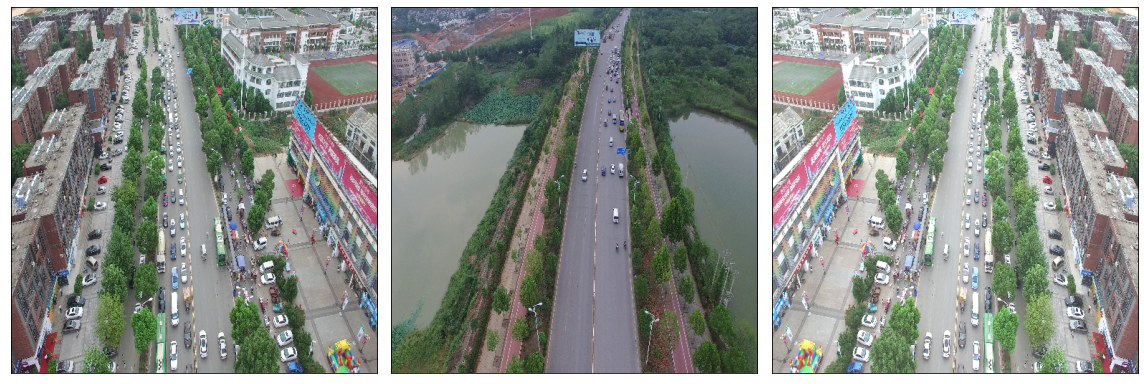

In [ ]:
indices = [0, 100, 200]
plot([train_dataset.get_np_image(index) for index in indices]);

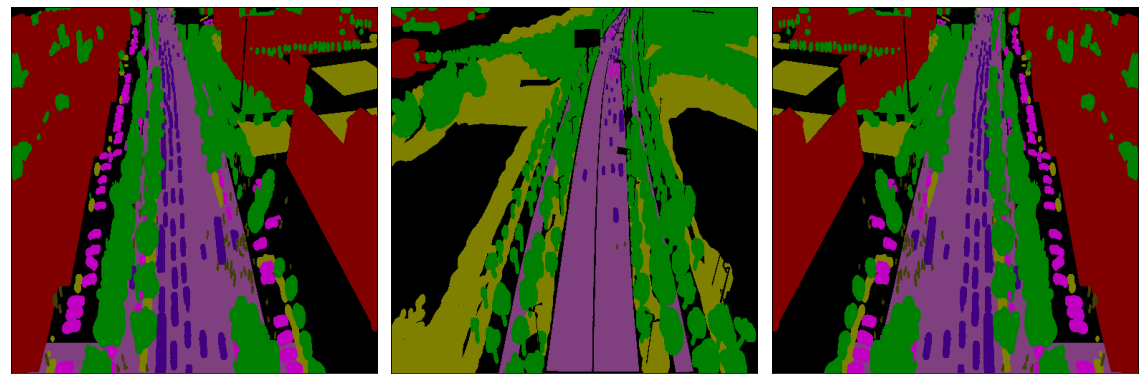

In [ ]:
indices = [0, 100, 200]
plot([train_dataset.get_np_label(index) for index in indices]);

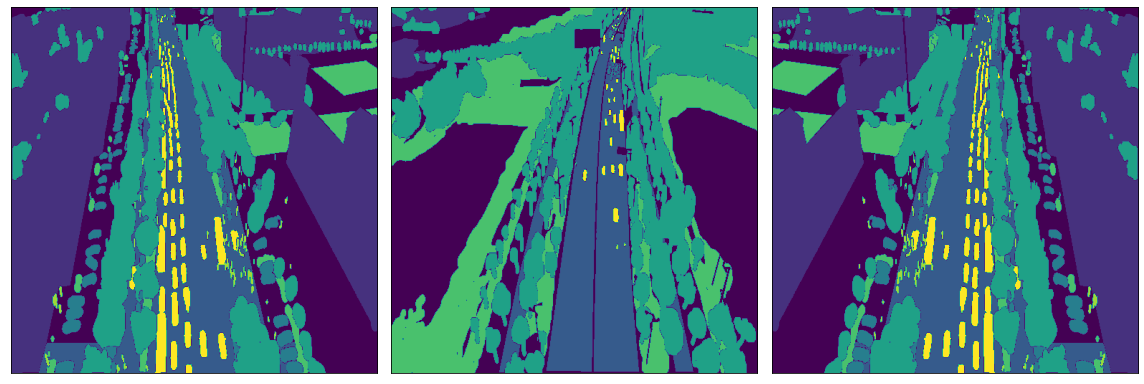

In [ ]:
indices = [0, 100, 200]
plot([train_dataset[index][1].squeeze(0).numpy() for index in indices]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


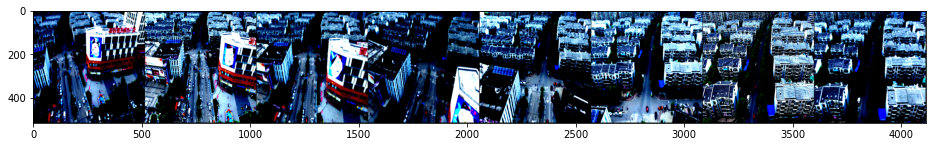

In [ ]:
images, _ = next(iter(val_dataloader))
plt.figure(figsize=(16, 8))
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0));

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model = UAVIDSemanticSegmentationModel(num_classes=NUM_CLASSES).to(device)
# model = ResNetUNet(NUM_CLASSES).to(device)
model = ENet(num_classes=NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training

In [ ]:
model.train()

for epoch in range(EPOCHS):
    running_loss = list()

    for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
    
    print(f'epoch: {epoch:2d}, iteration: {i + 1:4d}, loss: {sum(running_loss) / len(running_loss):.4f}')
            
model.eval();

  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 75/75 [06:47<00:00,  5.44s/it]

epoch:  0, iteration:   75, loss: 1.8169



100%|██████████| 75/75 [04:32<00:00,  3.63s/it]

epoch:  1, iteration:   75, loss: 1.3411



100%|██████████| 75/75 [04:23<00:00,  3.52s/it]

epoch:  2, iteration:   75, loss: 1.1483



100%|██████████| 75/75 [04:37<00:00,  3.70s/it]

epoch:  3, iteration:   75, loss: 1.0495



100%|██████████| 75/75 [04:28<00:00,  3.58s/it]

epoch:  4, iteration:   75, loss: 0.9820



100%|██████████| 75/75 [04:26<00:00,  3.56s/it]

epoch:  5, iteration:   75, loss: 0.9329



100%|██████████| 75/75 [04:27<00:00,  3.57s/it]

epoch:  6, iteration:   75, loss: 0.8904



100%|██████████| 75/75 [04:34<00:00,  3.66s/it]

epoch:  7, iteration:   75, loss: 0.8608



100%|██████████| 75/75 [04:26<00:00,  3.55s/it]

epoch:  8, iteration:   75, loss: 0.8228



100%|██████████| 75/75 [04:28<00:00,  3.59s/it]

epoch:  9, iteration:   75, loss: 0.7931



100%|██████████| 75/75 [04:27<00:00,  3.57s/it]

epoch: 10, iteration:   75, loss: 0.7937



100%|██████████| 75/75 [04:24<00:00,  3.53s/it]

epoch: 11, iteration:   75, loss: 0.7717



100%|██████████| 75/75 [04:25<00:00,  3.55s/it]

epoch: 12, iteration:   75, loss: 0.7307



100%|██████████| 75/75 [04:22<00:00,  3.50s/it]

epoch: 13, iteration:   75, loss: 0.7069



100%|██████████| 75/75 [04:20<00:00,  3.48s/it]

epoch: 14, iteration:   75, loss: 0.7111



100%|██████████| 75/75 [04:32<00:00,  3.63s/it]

epoch: 15, iteration:   75, loss: 0.6988



100%|██████████| 75/75 [04:30<00:00,  3.61s/it]

epoch: 16, iteration:   75, loss: 0.6695



100%|██████████| 75/75 [04:23<00:00,  3.52s/it]

epoch: 17, iteration:   75, loss: 0.6608



100%|██████████| 75/75 [04:13<00:00,  3.38s/it]

epoch: 18, iteration:   75, loss: 0.6417



100%|██████████| 75/75 [04:22<00:00,  3.50s/it]

epoch: 19, iteration:   75, loss: 0.6231



100%|██████████| 75/75 [04:25<00:00,  3.54s/it]

epoch: 20, iteration:   75, loss: 0.6234



100%|██████████| 75/75 [04:22<00:00,  3.50s/it]

epoch: 21, iteration:   75, loss: 0.6117



100%|██████████| 75/75 [04:19<00:00,  3.47s/it]

epoch: 22, iteration:   75, loss: 0.6145



100%|██████████| 75/75 [04:15<00:00,  3.40s/it]

epoch: 23, iteration:   75, loss: 0.6051



100%|██████████| 75/75 [04:10<00:00,  3.34s/it]

epoch: 24, iteration:   75, loss: 0.5912



100%|██████████| 75/75 [04:26<00:00,  3.55s/it]

epoch: 25, iteration:   75, loss: 0.5848



100%|██████████| 75/75 [04:13<00:00,  3.37s/it]

epoch: 26, iteration:   75, loss: 0.5665



100%|██████████| 75/75 [04:12<00:00,  3.36s/it]

epoch: 27, iteration:   75, loss: 0.5553



100%|██████████| 75/75 [04:09<00:00,  3.33s/it]

epoch: 28, iteration:   75, loss: 0.5628



100%|██████████| 75/75 [04:13<00:00,  3.38s/it]

epoch: 29, iteration:   75, loss: 0.5424



100%|██████████| 75/75 [04:20<00:00,  3.47s/it]

epoch: 30, iteration:   75, loss: 0.5343



100%|██████████| 75/75 [04:09<00:00,  3.32s/it]

epoch: 31, iteration:   75, loss: 0.5365



100%|██████████| 75/75 [04:12<00:00,  3.36s/it]

epoch: 32, iteration:   75, loss: 0.5287



100%|██████████| 75/75 [04:15<00:00,  3.40s/it]

epoch: 33, iteration:   75, loss: 0.5189



100%|██████████| 75/75 [04:16<00:00,  3.43s/it]

epoch: 34, iteration:   75, loss: 0.5069



100%|██████████| 75/75 [04:11<00:00,  3.36s/it]

epoch: 35, iteration:   75, loss: 0.5011



100%|██████████| 75/75 [04:10<00:00,  3.34s/it]

epoch: 36, iteration:   75, loss: 0.5010



100%|██████████| 75/75 [04:18<00:00,  3.44s/it]

epoch: 37, iteration:   75, loss: 0.5092



100%|██████████| 75/75 [04:08<00:00,  3.32s/it]

epoch: 38, iteration:   75, loss: 0.4905



100%|██████████| 75/75 [04:07<00:00,  3.30s/it]

epoch: 39, iteration:   75, loss: 0.4843



100%|██████████| 75/75 [04:01<00:00,  3.22s/it]

epoch: 40, iteration:   75, loss: 0.4863



100%|██████████| 75/75 [04:18<00:00,  3.44s/it]

epoch: 41, iteration:   75, loss: 0.4744



100%|██████████| 75/75 [04:15<00:00,  3.41s/it]

epoch: 42, iteration:   75, loss: 0.4829



100%|██████████| 75/75 [04:12<00:00,  3.37s/it]

epoch: 43, iteration:   75, loss: 0.4951



100%|██████████| 75/75 [04:02<00:00,  3.23s/it]

epoch: 44, iteration:   75, loss: 0.4895



100%|██████████| 75/75 [04:08<00:00,  3.32s/it]

epoch: 45, iteration:   75, loss: 0.4724



100%|██████████| 75/75 [04:10<00:00,  3.35s/it]

epoch: 46, iteration:   75, loss: 0.4542



100%|██████████| 75/75 [04:09<00:00,  3.33s/it]

epoch: 47, iteration:   75, loss: 0.4538


# Saving model

In [ ]:
torch.save(model.state_dict(), CHECKPOINT_PATH)

# Loading model

In [ ]:
model.load_state_dict(torch.load(CHECKPOINT_PATH))
model.eval();

# Evaluation

In [ ]:
evaluate(model, train_dataloader, train=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


mIOU of the network on the 600 train images: 0.345 %


In [ ]:
evaluate(model, val_dataloader, train=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


mIOU of the network on the 72 test images: 0.305 %


# Visualization

In [ ]:
def plot_model_preds(index):
    color_transformer = UAVIDDataset(dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH)

    with torch.no_grad():
        image, label = val_dataset[index]
        image = image.to(device)
        label = label.to(device)
        outputs = model(image.unsqueeze(0))
        _, outputs = torch.max(outputs, 1)
        outputs = outputs.squeeze(0).cpu().numpy()
        outputs_colored = color_transformer.inverse_transform(outputs)
        image = image.cpu().numpy()
        label = label.cpu().numpy()
        label_colored = color_transformer.inverse_transform(label)

    plot([val_dataset.get_np_image(index), outputs_colored, label_colored]);

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


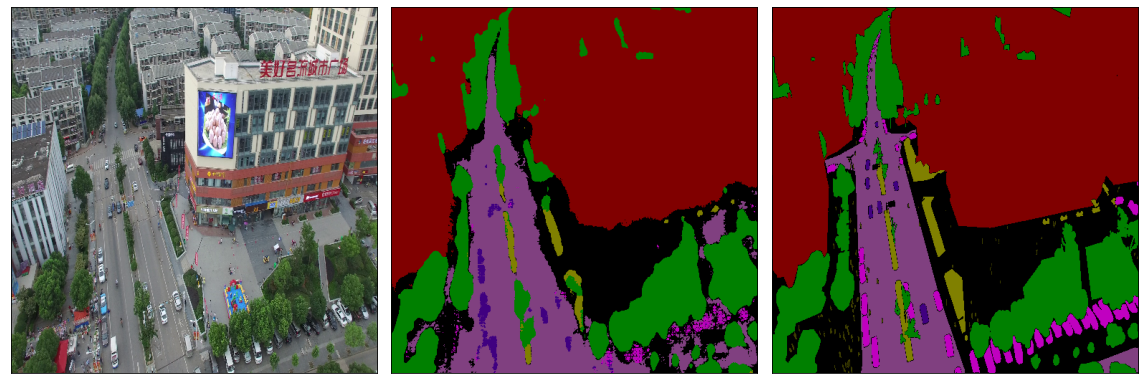

In [ ]:
ipywidgets.interact(
    plot_model_preds,    
    index=ipywidgets.IntText(min=0, max=len(val_dataset), step=1, value=0));

# What's next?

In order to boost segmentation accuracy you can:
 - Use State-Of-The-Art model architecture
 - Change Loss function
 - Play with learning_rate of optimizer
 - Increase image resolution
 - Add image augmenations

In [ ]:
print(model.__class__.__name__)
print(criterion.__class__.__name__)
print(optimizer.__class__.__name__)
print(IMAGE_HEIGHT)
print(EPOCHS)

ENet
CrossEntropyLoss
Adam
512
48


base: image size 256x256 | 8 epoch | 

| Model | Loss  | Optimizer | train | test | additional | conclusion |
| :-----: | :-: | :-: | :-: | :-: | :-: | :-: |
| Segnet | CrossEntropyLoss | SGD | 0.182 | 0.177 | - | 
| Segnet | Focal | SGD | 0.183 | 0.175 | - | 
| Segnet | Focal | Adam | 0.235 | 0.219 | - | 
| Segnet | CrossEntropyLoss | Adam | 0.261 (0.283) | 0.251 (0.267)| - | Adam > SGD|
| Unet | CrossEntropyLoss | Adam | 0.173 | 0.164 | - | 
| Unet | Focal | Adam | 0.233 (0.199) | 0.216 (0.188) | - | focal loss for Unet
| Unet | Focal | Adam | 0.162 | 0.172 | aug |
| Unet | Focal | Adam | 0.216 | 0.201 | 512 image size | increase image size not giving better results
| Unet | Focal | Adam | 0.21 | 0. | 512 image size + 20 epoch |
| Unet | Focal | Adam | 0.17 | 0.167 | 256 image size + 16 epoch |
| Unet | Focal | Adam | 0.17 | 0.162 | 256 image size + 20 epoch + lr=0.0001|
| ENet | Focal | Adam | 0.222 | 0.209 | 512 image size | 
| ENet | CrossEntropyLoss | Adam | 0.233 | 0.221| 512 image size | UNet < ENet < Segnet. Choosing ENet for architecture testing
| ENet | CrossEntropyLoss | Adam | 0.307 | 0.277| 512 image size + 32 epoch + lr=0.0005 | 
| ENet | CrossEntropyLoss | Adam | 0.345 | ***0.305***| 512 image size + 48 epoch + lr=0.0005 |